# Laboratorio 7: Clasificación 🤗

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos - Primavera 2024</strong></center>


### Cuerpo Docente:

- Profesores: Ignacio Meza, Sebastián Tinoco
- Auxiliar: Eduardo Moya
- Ayudantes: Nicolás Ojeda, Melanie Peña, Valentina Rojas

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Tomás Ignacio Reyes Oyarzún

### **Link de repositorio de GitHub:** [Repo - TR](https://github.com/TomiReyes/MDS7202-TR)

### Temas a tratar
- Clasificación en problemas desbalanceados
- Lightgbm y xgboost
- Pipelines

### Reglas:

- **Grupos de 2 personas**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.
- Código que no se pueda ejecutar, no será revisado.



### Objetivos principales del laboratorio
- Comprender cómo trabajar con problemas de clasificación con clases desbalanceadas.
- Aplicar los modelos lightgbm y xgboost.
- Practicar Pipelines

# Parte Teórica [12 puntos]




1. Explique cuál es la diferencia entre los datos de entrenamiento y validación. [1 punto]

2. Explique cuál es el principal desafío al trabajar problemas de clasificación con data no supervisada. [1 punto]

3. Explique en **sus palabras** qué es la matriz de confusión y para qué se utiliza. [1 puntos]

4. Escriba la fórmula de las siguientes métricas y explique con **sus palabras** cómo se interpretan. [1 punto cada uno]

  * Accuracy
  * Precision
  * Recall
  * F1 score

5. Explique qué métrica recomendaría para los siguientes contextos de clasificación. [1 punto cada uno]

  * Mantenimiento predictivo de fallas de maquinaria pesada en la industria minera.  
  * Detección de enfermedades altamente contagiosas.
  * Aprobación de créditos de alto riesgo.
  * Detección de crímenes.

6. Explique qué es la calibración de modelos y para qué se usa. [1 punto]


**Respuesta:**

1. Los datos de entrenamiento son necesarios para que el modelo aprenda de esos datos, de manera que pueda tener el conocimiento de cara a datos nuevos y generar predicciones. Los datos de validación permiten evaluar el rendimiento del modelo, así como si trataran de datos "nuevos" para ver como se comporta el modelo.

2. La dificultad está en que no se sabe a que clasificación pertenece cada dato, por lo que es más complicado validar si la clasificación está bien o no, dado que no hay información previa. 

3. La matriz de confusión permite saber cada caso de los resultados, los verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos. De este modo, hacer una estimación de como fue el comportamiento respecto a un tipo de etiqueta u otra.

4. Con los valores como VP VN FP y FN se tiene lo siguiente:
 * Accuracy: (VP + VN) / (VP + VN + FP + FN). Corresponde a la proporción de datos correctos ya que son los casos verdaderos sobre el total. 
 * Precision: VP / (VP + FP). Corresponde a las predicciones positivas hechas, donde se castiga más tener falsos positivos, ya que está en el denominador. 
 * Recall: VP / (VP + FN). Corresponde a las predicciones positivas hechas respecto a la importancia de detectar la mayor cantidad de casos positivos, donde castiga tener más casos de falsos negativos. 
 * F1 score: 2  * [(Precision * Recall) / Precision + Recall]. Es la proporción de las métricas anteriores. Se utiliza sobre todo cuando las clases están desbalanceadas.

5.  * Recall, ya que es necesario tener la menor cantidad de falsos negativos, por lo peligroso que puede llegar a ser. 
    * Recall, por lo mismo, es necesario tener lo minimo de falsos negativos, porque lo ideal es alcanzar el máximo de casos verdaderos. 
    * Precision, porque hay que castigar más el caso de falsos positivos, en referencia a que darle el crédito a alguien que no lo merece es peligroso. 
    * F1 score, dado que las etiquetadas deben estar desbalanceadas y es necesario mantener un equilibrio entre priorizar casos falsos positivos o negativos. 

6. Calibrar un modelo es tratar la predicción probabilistica para que sea más adecuada a cada situación. Se usa para ajustar la interpretación en situaciones donde la probabilidad tiene un mayor impacto en el resultado.  

# Parte práctica [48 puntos]

<p align="center">
  <img src="https://i.ibb.co/61L8z0w/renacin-by-volframio-dcirf4l-fullview.jpg"
" width="400">
</p>



Tras el trágico despido de la mítica mascota de Maipú, Renacín decide adentrarse como consultor en el mercado futbolero, el cuál (para variar...) está cargado en especulaciones.

Como su principal tarea será asesorar a los directivos de los clubes sobre cuál jugador comprar y cuál no, Renacín desea generar modelos predictivos que evaluén distintas características de los jugadores; todo con el fin de tomar decisiones concretas basadas en los datos.

Sin embargo, su condición de corporeo le impidió tomar la versión anterior de MDS7202, por lo que este motivo Renacín contrata a su equipo para lograr su objetivo final. Dado que aún tiene fuertes vínculos con la dirección de deportes de la municipalidad, el corporeo le entrega base de datos con las estadísticas de cada jugador para que su equipo empieze a trabajar ya con un dataset listo para ser usado.


**Los Datos**

Para este laboratorio deberán trabajar con el csv `statsplayers.csv`, donde deberán aplicar algoritmos de aprendizaje supervisado de clasificación en base a características que describen de jugadores de fútbol.

Para comenzar cargue el dataset señalado y a continuación vea el reporte **`Player_Stats_Report.html`** (adjunto en la carpeta del enunciado) que describe las características principales del `DataFrame`.

In [88]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.feature_extraction import FeatureHasher 

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, brier_score_loss

from pycaret.datasets import get_data
from pycaret.classification import *
import os

os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

from sklearn.feature_selection import RFE
import xgboost as xgb

from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

## 1. Predicción de Seleccionados Nacionales [14 puntos]

<p align="center">
  <img src="https://www.futuro.cl/wp-content/uploads/2016/06/chile-argentina-meme-12.jpg" width="300">
</p>



### 1.1 Preprocesamiento [5 puntos]

Tareas:

1. Genere los labels para la clasificación binaria en una variable llamada `label`. Para esto, trabaje sobre el atributo `National_Position` suponiendo que los valores nulos son jugadores no seleccionados para representar a su país. [Sin puntaje]

2. Hecho esto, ¿cuántos se tienen ejemplos por cada clase? Comente lo que observa. [1 punto]

3. Genere un `ColumnTransformer` en donde especifique las transformaciones que hay que realizar para cada columna (por ejemplo StandarScaler, MinMaxScaler, OneHotEncoder, etc...) para que puedan ser utilizadas correctamente por el modelo predictivo y guárdelo una variable llamada `col_transformer`. [2 puntos]

4. Comente y justifique las transformaciones elegidas sobre cada una de las variables (para esto utilice el material `Player_Stats_Report.html` que viene en el zip del lab), al igual que las transformaciones aplicadas. [2 puntos]

**Respuesta:**

In [67]:
df = pd.read_csv('stats_players.csv')
df.head(2)

,Name,Nationality,National_Position,Club_Position,Height,Weight,Preffered_Foot,Age,Work_Rate,Weak_foot,...,Agility,Jumping,Heading,Shot_Power,Finishing,Long_Shots,Curve,Freekick_Accuracy,Penalties,Volleys
0,Cristiano Ronaldo,Portugal,LS,LW,185,80,Right,32,High / Low,4,...,90,95,85,92,93,90,81,76,85,88
1,Lionel Messi,Argentina,RW,RW,170,72,Left,29,Medium / Medium,4,...,90,68,71,85,95,88,89,90,74,85


In [68]:
df['label'] = df['National_Position'].notnull().astype(int)
df['label'].value_counts()

label
0    16513
1     1075
Name: count, dtype: int64

In [69]:
df['Nationality'] = df['Nationality'].apply(lambda x: [str(x)])
df['Club_Position'] = df['Club_Position'].apply(lambda x: [str(x)])

df['Preffered_Foot'] = df['Preffered_Foot'].astype(str)
df['Work_Rate'] = df['Work_Rate'].astype(str)

In [70]:
col_transformer = ColumnTransformer(
    transformers=[
        # FeatureHasher para variables categóricas con muchas categorías
        ('nationality_fh', FeatureHasher(n_features=16, input_type='string'), 'Nationality'),
        #('club_position_fh', FeatureHasher(n_features=10, input_type='string'), 'Club_Position'),

        # StandardScaler para variables numéricas
        ('height_std', StandardScaler(), ['Height']),
        ('weight_std', StandardScaler(), ['Weight']),
        ('aggression_std', StandardScaler(), ['Aggression']),
        ('reactions_std', StandardScaler(), ['Reactions']),
        ('vision_std', StandardScaler(), ['Vision']),
        ('strength_std', StandardScaler(), ['Strength']),
        ('balance_std', StandardScaler(), ['Balance']),
        ('agility_std', StandardScaler(), ['Agility']),
        ('jumping_std', StandardScaler(), ['Jumping']),
        ('penalties_std', StandardScaler(), ['Penalties']),

        # OneHotEncoder para variables categóricas
        ('preferred_foot_ohe', OneHotEncoder(), ['Preffered_Foot']),
        ('work_rate_ohe', OneHotEncoder(), ['Work_Rate']),

        # MinMaxScaler para variables numéricas
        ('age_minmax', MinMaxScaler(), ['Age']),
        ('weak_foot_minmax', MinMaxScaler(), ['Weak_foot']),
        ('skill_moves_minmax', MinMaxScaler(), ['Skill_Moves']),
        ('marking_minmax', MinMaxScaler(), ['Marking']),
        ('sliding_tackle_minmax', MinMaxScaler(), ['Sliding_Tackle']),
        ('standing_tackle_minmax', MinMaxScaler(), ['Standing_Tackle']),
        ('interceptions_minmax', MinMaxScaler(), ['Interceptions']),
        ('finishing_minmax', MinMaxScaler(), ['Finishing']),
        ('long_shots_minmax', MinMaxScaler(), ['Long_Shots']),
        ('curve_minmax', MinMaxScaler(), ['Curve']),
        ('freekick_accuracy_minmax', MinMaxScaler(), ['Freekick_Accuracy']),
        ('volleys_minmax', MinMaxScaler(), ['Volleys']),

        # PowerTransformer para variables numéricas
        ('ball_control_power', PowerTransformer(), ['Ball_Control']),
        ('dribbling_power', PowerTransformer(), ['Dribbling']),
        ('composure_power', PowerTransformer(), ['Composure']),
        ('crossing_power', PowerTransformer(), ['Crossing']),
        ('short_pass_power', PowerTransformer(), ['Short_Pass']),
        ('long_pass_power', PowerTransformer(), ['Long_Pass']),
        ('acceleration_power', PowerTransformer(), ['Acceleration']),
        ('speed_power', PowerTransformer(), ['Speed']),
        ('stamina_power', PowerTransformer(), ['Stamina']),
        ('heading_power', PowerTransformer(), ['Heading']),
        ('shot_power_power', PowerTransformer(), ['Shot_Power']),
    ],
    remainder='drop'  
)

In [71]:
df_transformed = col_transformer.fit_transform(df)

df_transformed = pd.DataFrame(df_transformed)
df_transformed.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.743727,2.537156,2.143637,2.251311,1.801896,2.216362,2.399166,2.437277,2.374306,2.605106
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.229143,3.320805,1.647686,2.871431,2.700837,2.324399,1.846901,0.678081,1.195419,2.008334
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.130329,1.973737,1.509458,2.015927,1.630469,2.433712,2.174017,1.123340,0.517199,1.445037
3,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,2.189936,2.252789,1.647686,2.251311,0.739276,1.899886,0.847619,2.113847,1.682552,2.175459
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-1.399555,1.083175,-1.736063,-0.410047,0.364013,-0.642616,-0.465255,-1.315262,-1.547668,-1.622834


La elección de FeatureHasher es por la cantidad de valores posibles categóricos, que según investigado, permite mejores resultados que hacer un OneHotEncoder, basado en la cantidad de valores. Para el caso de StandardScaler, se aplica en todas las variables que su distribución asemeja a una distribución normal o al menos los valores están más centrados. Para el caso de OneHotEncoder, se aplica a las variables categóricas de etiquetas que tienen pocos valores y permite generar nuevas variables en base a valores binarios. MixMaxScaler, se aplicó a variables con valores más repartidos a partir de su rango de valores, por lo que no se pudo atribuir una distribución centrada. Y PowerTransform, se aplicó a variables que asemejan una distribución normal pero centrada a la derecha o la izquierda, como se ve en distintas distribuciones en el reporte. 

Las variables no específicadas con transformaciones no serán consideradas para realizar el entrenamiento y validación, entre estas variables están: 
Name, porque es casi como un id, lo que generaría problemas de clasificación. Sliding_Tackle, Standing_Tackle y Interceptions no son consideradas por su alta correlación con Marking, por lo que solo es necesario dejar una de la cuatro. Similar al caso de Dribbling, que no es considerada por su correlación con Ball_Control. Speed no es considerada por su correlación con Acceleration. Y Short_Pass no es considerada por su correlación con Long_Pass.

### 1.2 Entrenamiento [3 puntos]

Ahora, vamos a entrenar los pipelines generados en los pasos anteriores. Para esto, debe realizar las siguientes tareas:

1. Separe los datos de entrenamiento en un conjunto de entrenamiento y de prueba  (la proporción queda a su juicio). En este paso, seleccione los ejemplos de forma aleatoria e intente mantener la distribución original de labels de cada clase en los conjuntos de prueba/entrenamiento. (vea la documentación de `train_test_split`). [1 puntos]


2. Defina un pipeline llamado `pipeline_xgboost` y otro llamado `pipeline_lightgbm`. Estos pipelines deben tener el mismo ColumnTransformer definido en la sección de preprocesamiento, pero deben variar los clasificadores de acuerdo al nombre de cada pipeline. [1 puntos]

3. Entrene los pipelines. [1 punto]



**Respuesta:**

In [8]:
X = df.drop(columns=['label'])  
y = df['label']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

In [9]:
X_train_transformed = col_transformer.fit_transform(X_train)

In [10]:
# Pipeline para XGBoost
pipeline_xgboost = Pipeline(steps=[
    ('preprocessing', col_transformer), 
    ('classifier', XGBClassifier(random_state=10))
])

# Pipeline para LightGBM
pipeline_lightgbm = Pipeline(steps=[
    ('preprocessing', col_transformer),  
    ('classifier', LGBMClassifier(random_state=10))
])

# Entrenamiento de XGBoost
pipeline_xgboost.fit(X_train, y_train)

# Entrenamiento de LightGBM
pipeline_lightgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 752, number of negative: 11559
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2539
[LightGBM] [Info] Number of data points in the train set: 12311, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061084 -> initscore=-2.732483
[LightGBM] [Info] Start training from score -2.732483


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('nationality_fh',
                                                  FeatureHasher(input_type='string',
                                                                n_features=16),
                                                  'Nationality'),
                                                 ('club_position_fh',
                                                  FeatureHasher(input_type='string',
                                                                n_features=10),
                                                  'Club_Position'),
                                                 ('height_std',
                                                  StandardScaler(),
                                                  ['Height']),
                                                 ('weight_std',
                                                  StandardScaler(),
                                                  ['Weight']),
                                                 ('aggression_std',
                                                  StandardScale...
                                                  MinMaxScaler(),
                                                  ['Freekick_Accuracy']),
                                                 ('volleys_minmax',
                                                  MinMaxScaler(), ['Volleys']),
                                                 ('ball_control_power',
                                                  PowerTransformer(),
                                                  ['Ball_Control']),
                                                 ('dribbling_power',
                                                  PowerTransformer(),
                                                  ['Dribbling']),
                                                 ('composure_power',
                                                  PowerTransformer(),
                                                  ['Composure']),
                                                 ('crossing_power',
                                                  PowerTransformer(),
                                                  ['Crossing']), ...])),
                ('classifier', LGBMClassifier(random_state=10))])

### 1.3 Resultados [6 puntos]

1. Calcule las métricas accuracy, precisión y recall de la clase positiva (la que indica que un jugador es seleccionado nacional) para evaluar el rendimiento de los distintos modelos. Verifique sus resultados usando `classification_report`. [2 puntos]

2. Explique qué implican los valores de accuracy, precisión y recall de la clase positiva (la que indica que un jugador es seleccionado nacional) y cómo influye la cantidad de ejemplos por clase en los resultados obtenidos. [2 puntos]

3. Explique qué métrica le parece más adecuada y concluya qué modelo tiene un mejor desempeño. [2 puntos]

**Respuesta:**

In [11]:
y_pred_xgboost = pipeline_xgboost.predict(X_test)
y_pred_lightgbm = pipeline_lightgbm.predict(X_test)

# Calcular métricas para XGBoost
print("XGBoost Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgboost))
print("Precision:", precision_score(y_test, y_pred_xgboost, pos_label=1))
print("Recall:", recall_score(y_test, y_pred_xgboost, pos_label=1))
print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgboost, target_names=["No seleccionado", "Seleccionado"]))

# Calcular métricas para LightGBM
print("LightGBM Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_lightgbm))
print("Precision:", precision_score(y_test, y_pred_lightgbm, pos_label=1))
print("Recall:", recall_score(y_test, y_pred_lightgbm, pos_label=1))
print("\nClassification Report (LightGBM):")
print(classification_report(y_test, y_pred_lightgbm, target_names=["No seleccionado", "Seleccionado"]))

XGBoost Model Performance:
Accuracy: 0.9393594845556187
Precision: 0.512
Recall: 0.19814241486068113

Classification Report (XGBoost):
                 precision    recall  f1-score   support

No seleccionado       0.95      0.99      0.97      4954
   Seleccionado       0.51      0.20      0.29       323

       accuracy                           0.94      5277
      macro avg       0.73      0.59      0.63      5277
   weighted avg       0.92      0.94      0.93      5277

LightGBM Model Performance:
Accuracy: 0.9399279893879098
Precision: 0.5294117647058824
Recall: 0.16718266253869968

Classification Report (LightGBM):
                 precision    recall  f1-score   support

No seleccionado       0.95      0.99      0.97      4954
   Seleccionado       0.53      0.17      0.25       323

       accuracy                           0.94      5277
      macro avg       0.74      0.58      0.61      5277
   weighted avg       0.92      0.94      0.92      5277



2. 
El accuracy tiene un valor alto para los dos modelos, lo cual está algo sesgado por el desbalance de los datos, esto se ve reflejado por los valores de precision y recall, ya que tienen valores muy bajos, eso implica que hay muchos casos de falsos positivos o falsos negativos. Tener los datos desbalanceados hace que el modelo no entrene bien esos casos y, por lo tanto, que no tenga buenos resultados generales. 

3. 
Cuando hay tanto desbalance, lo mejor es considerar el F1, ya que trata mejor estas situaciones. Analizando esta métrica, el mejor modelo es el XGboost, aunque por poca diferencia. 

## 2. Predicción de posiciones de jugadores [4 puntos]

<p align="center">
  <img src="https://pbs.twimg.com/media/E1rfA1aWEAYU6Ny.jpg" width="300">
</p>

En una nueva jornada de desmesuradas transacciones deportivas, Renacín escuchó a sus colegas discutir acerca de que el precio de cada jugador depende en gran medida de la posición en la cancha en la que juega. Y además, que hay bastantes jugadores nuevos que no tienen muy claro en que posición verdaderamente brillarían, por lo que actualmente puede que actualmente estén jugando en posiciones sub-optimas.

Viendo que los resultados del primer análisis no son tan esperanzadores, el corporeo los comanda a cambiar su tarea: ahora, les solicita que construyan un clasificador enfocado en predecir la mejor posición de los jugadores en la cancha según sus características.

Para lograr esto, primero, les pide que etiqueten de la siguiente manera los valores que aparecen en el atributo `Club_Position`, pidiendo que agrupen los valores en los siguientes grupos:

**Nota**:  Renacín les recalca que **no deben utilizar los valores ```Sub``` y ```Res``` de esta columna**.

```python
ataque = ['ST', 'CF']
central_ataque = ['RW', 'CAM', 'LW']
central = ['RM', 'CM', 'LM']
central_defensa = ['RWB', 'CDM', 'LWB']
defensa = ['RB', 'CB', 'LB']
arquero = ['GK']
```

La elección del clasificador se justificar en base a la siguiente [guía](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) y se deben comentar los resultados obtenidos en la clasificación.

**Tareas:** [1 punto por tarea]

1. En un nuevo dataframe, aplique las etiquetas descritas anteriormente en cada uno de los valores señalados en esta sección y guárdelos en la variable `label`.
2. Cuente cuántos por clase quedan.
3. Entrene el nuevo pipeline y ejecute una evaluación de este.  
4. Comente los resultados obtenidos.

**Respuesta:**

In [44]:
ataque = ['ST', 'CF']
central_ataque = ['RW', 'CAM', 'LW']
central = ['RM', 'CM', 'LM']
central_defensa = ['RWB', 'CDM', 'LWB']
defensa = ['RB', 'CB', 'LB']
arquero = ['GK']

In [45]:
df['Nationality'] = df['Nationality'].apply(lambda x: x[0] if isinstance(x, list) else x)
df['Club_Position'] = df['Club_Position'].apply(lambda x: x[0] if isinstance(x, list) else x)

In [52]:
df_new = df.copy()

def asignar_label(posicion):
    if posicion in ataque:
        return 'ataque'
    elif posicion in central_ataque:
        return 'central_ataque'
    elif posicion in central:
        return 'central'
    elif posicion in central_defensa:
        return 'central_defensa'
    elif posicion in defensa:
        return 'defensa'
    elif posicion in arquero:
        return 'arquero'
    else:
        return None  

df_new['label'] = df_new['Club_Position'].apply(asignar_label)

df_new = df_new[~df_new['Club_Position'].isin(['Sub', 'Res'])]
print(df_new.shape)
df_new = df_new.dropna(subset=['label'])
print(df_new.shape)


(6950, 40)
(3939, 40)


In [53]:
df_new["label"].value_counts()

label
defensa            1180
central             907
arquero             632
central_ataque      581
ataque              430
central_defensa     209
Name: count, dtype: int64

In [54]:
df_new['Nationality'] = df_new['Nationality'].apply(lambda x: [str(x)])
df_new['Club_Position'] = df_new['Club_Position'].apply(lambda x: [str(x)])

In [62]:
X = df_new.drop(columns=['label'])  
y = df_new['label']  

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=10)

pipeline_xgboost = Pipeline(steps=[
    ('preprocessing', col_transformer),  
    ('classifier', XGBClassifier(random_state=10))
])

# Entrenar el modelo
pipeline_xgboost.fit(X_train, y_train)


y_pred = pipeline_xgboost.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       124
           1       0.85      0.89      0.87        91
           2       0.56      0.62      0.59       186
           3       0.51      0.36      0.42       129
           4       0.64      0.26      0.37        27
           5       0.85      0.96      0.90       231

    accuracy                           0.75       788
   macro avg       0.73      0.68      0.69       788
weighted avg       0.74      0.75      0.74       788



In [63]:
df_new["label"].value_counts() 

label
defensa            1180
central             907
arquero             632
central_ataque      581
ataque              430
central_defensa     209
Name: count, dtype: int64

4. 
Se oserva que el accuracy general es de 75% lo cual es un buen resultado ya que se contaba con pocos datos en general. Viendo los resultados y la cantidad de datos por etiqueta, hace sentido las diferencias de resultados en base a la diferencia de cantidad de datos que hay para cada clase.

## 3. Predicciones de Seleccionados Nacionales para el Jere Klein [30 puntos]

<center>
<img src='https://www.radioactiva.cl/wp-content/uploads/2024/04/Jere-Klein-1-768x432.webp' width=500 />

Después de alcanzar la fama como cantante urbano, Jere Klein decide explorar una nueva faceta. Con su amor por el fútbol y convencido de que los artistas urbanos poseen un talento y versatilidad excepcionales, Jere se embarca en un proyecto innovador: desarrollar un sistema de inteligencia artificial capaz de identificar a jugadores que tienen potencial para convertirse en futbolistas profesionales. Su teoría es que muchos artistas del género urbano chileno, con sus habilidades únicas y su disciplina, podrían destacarse también en el deporte. Con este sistema, Jere espera no solo abrir nuevas oportunidades para sus colegas artistas, sino también demostrar la amplia gama de talentos que pueden ofrecer.

### 2.1 ¿Qué modelo de árbol es más de "pana"? [10 puntos]

<center>
<img src='https://64.media.tumblr.com/39189215a7d3d96823cb359f35b44e05/tumblr_psmrhrR3Xw1qf5hjqo4_540.gif' width=300 />


**Tareas**


1. Considerando el la variable llamada `label` creada en la sección 1.1. Para determinar cuál modelo de árbol sería más adecuado para la tarea en cuestión, utilice PyCaret. Este deberá centrarse exclusivamente en modelos de tipo árbol. Jere ha especificado que busca un modelo que tome decisiones rápidamente y que tenga una baja tasa de falsos positivos, ya que planea invertir en estos jugadores. [3 puntos] 

Para la comparación, utilice los siguientes modelos:

```python
['et', 'rf', 'dt', 'xgboost', 'lightgbm', 'catboost']
```

2. Explique en brevemente que son los modelos de la siguiente lista `['et', 'rf', 'dt']` y como funcionan. [3 punto]

3. Tras realizar la comparación de modelos, seleccione aquel que muestre el mejor rendimiento en términos de velocidad y precisión, especialmente en la reducción de falsos positivos. Utilice la función `evaluate_model` de PyCaret para revisar y analizar los resultados obtenidos en los siguientes aspectos:

  - **Confusión Matrix**: ¿Cómo se encuentran la tasa de verdaderos positivos y verdaderos negativos?
  - **Threshold**: ¿Es acaso el umbral por defecto del modelo el mejor para las predicciones?
  - **Feature Importance**: ¿Cuáles son las variables con mejor desempeño? ¿A qué podría deberse esto?
  - **Learning Curve**: ¿El modelo presenta algún problema?

  [4 puntos]

**Respuesta**

In [74]:
# Concatenar el DataFrame transformado con la columna 'label' usando el índice
df_combined = pd.concat([df_transformed, df['label']], axis=1)

# Mostrar el DataFrame resultante
df_combined.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.537156,2.143637,2.251311,1.801896,2.216362,2.399166,2.437277,2.374306,2.605106,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.320805,1.647686,2.871431,2.700837,2.324399,1.846901,0.678081,1.195419,2.008334,1
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.973737,1.509458,2.015927,1.630469,2.433712,2.174017,1.123340,0.517199,1.445037,1
3,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,2.252789,1.647686,2.251311,0.739276,1.899886,0.847619,2.113847,1.682552,2.175459,1
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.083175,-1.736063,-0.410047,0.364013,-0.642616,-0.465255,-1.315262,-1.547668,-1.622834,1


In [75]:
clf = setup(data=df_combined, 
            target='label', 
            session_id=10)  

models_to_compare = ['et', 'rf', 'dt', 'xgboost', 'lightgbm']

best_model = compare_models(include=models_to_compare, sort='Precision')

evaluate_model(best_model)

,Description,Value
0,Session id,10
1,Target,label
2,Target type,Binary
3,Original data shape,"(17588, 61)"
4,Transformed data shape,"(17588, 61)"
5,Transformed train set shape,"(12311, 61)"
6,Transformed test set shape,"(5277, 61)"
7,Numeric features,60
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9413,0.8875,0.0612,0.7330,0.1115,0.1033,0.1958,0.1560
rf,Random Forest Classifier,0.9414,0.8776,0.0944,0.6436,0.1630,0.1499,0.2286,0.2930
lightgbm,Light Gradient Boosting Machine,0.9412,0.9013,0.1955,0.5515,0.2881,0.2648,0.3043,0.2830
xgboost,Extreme Gradient Boosting,0.9394,0.8899,0.1942,0.5127,0.2800,0.2552,0.2891,0.0520
dt,Decision Tree Classifier,0.9079,0.6227,0.2979,0.2676,0.2809,0.2320,0.2329,0.0610


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

2. 
    * rf es randon forest, donde se utilizan distintos nodos de decision formando un arbol, cada nodo es independiente del otro y su forma de enlazar la información depende el método que se use.
    * et son extra trees classifier, es una variante del randon forest que genera más aleatoriedad al momento de ver el tema de los árboles, generando resultados más robustos. 
    * dt decision tree, va diviendo los datos en base a decisiones en casos más específicos, tomando una desicion final.

3. Tras realizar la comparación de modelos, seleccione aquel que muestre el mejor rendimiento en términos de velocidad y precisión, especialmente en la reducción de falsos positivos. Utilice la función `evaluate_model` de PyCaret para revisar y analizar los resultados obtenidos en los siguientes aspectos:

  - **Confusión Matrix**: VP es 20, VN es 4946, pero tiene 303 FN, por lo que el modelo tiene un bajo recall. 
  - **Threshold**: el umbral por defecto no es el mejor para las predicciones, ajustandolo se podrían tener mejores resultados.
  - **Feature Importance**: ¿Cuáles son las variables con mejor desempeño? ¿A qué podría deberse esto?
  - **Feature Importance**: Al trabajar con el modelo procesado, no es claro cuales son las variables más importantes pero son la 19, 51, 53 y 49. De todos modos no son tanto mayor importante que el resto.
  - **Learning Curve**: No presenta problemas mayores, hay diferencia para el caso de entrenamiento y validación pero que es normal.

### 2.2 Reducción de dimensionalidad [14 puntos]

<center>
<img src='https://i.kym-cdn.com/photos/images/original/002/258/560/668.gif' width=400 />

A pesar de los resultados obtenidos previamente, el manager de Jere ha solicitado el entrenamiento de un modelo de XGBoost utilizando los datos disponibles. Además, se debe proceder a realizar una reducción de dimensionalidad basada en la importancia de las características.

Para llevar a cabo esta tarea:

1. Inicie entrenando un modelo XGBoost con todas las características disponibles. [2 puntos]

2. Una vez el modelo esté entrenado, evalúe y clasifique las características según su importancia de forma descendente. [2 puntos]

3. Utilice esta clasificación para ejecutar una búsqueda recursiva de eliminación de características, eliminando progresivamente las menos importantes y evaluando el impacto en el desempeño del modelo hasta identificar las N características más críticas. [2 puntos]

4. Con este conjunto reducido de características, entrene un nuevo modelo y evalúe su rendimiento. [2 puntos]

5. Posteriormente, responda a las siguientes preguntas para una comprensión más profunda de los cambios y beneficios:

  - ¿El rendimiento del modelo con las características seleccionadas es similar al del modelo original? ¿Cómo se comparan en términos de precisión y robustez? [2 puntos]
  - ¿Cuáles son los beneficios potenciales de eliminar variables del modelo? Considere factores como la simplificación del modelo, reducción del tiempo de entrenamiento, y mejora en la capacidad de generalización. [2 puntos]
  - Comente si el modelo con menor dimensionalidad es más sencillo de explicar. Explique brevemente por qué la eliminación de ciertas características puede facilitar la comprensión y la explicación del comportamiento del modelo. [2 puntos]

Notar que con esta metodologia buscamos encontrar un punto entermedio entre número de festures y desempeño. por esto, si observa que al aumentar festires el aumento es despreciable, puede no considerar agregar más features a su modelo.

**Respuesta**

In [83]:
clf = setup(data=df_combined, target='label', session_id=10)

xgboost_model = create_model('xgboost')

,Description,Value
0,Session id,10
1,Target,label
2,Target type,Binary
3,Original data shape,"(17588, 61)"
4,Transformed data shape,"(17588, 61)"
5,Transformed train set shape,"(12311, 61)"
6,Transformed test set shape,"(5277, 61)"
7,Numeric features,60
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9383,0.8631,0.1316,0.5000,0.2083,0.1874,0.2340
1,0.9334,0.9109,0.1600,0.3871,0.2264,0.1978,0.2192
2,0.9374,0.8928,0.2000,0.4688,0.2804,0.2532,0.2785
3,0.9334,0.8498,0.1333,0.3704,0.1961,0.1693,0.1937
4,0.9464,0.8718,0.2800,0.6364,0.3889,0.3653,0.3993
5,0.9472,0.9122,0.2533,0.6786,0.3689,0.3473,0.3939
6,0.9439,0.8942,0.2267,0.6071,0.3301,0.3071,0.3484
7,0.9439,0.8977,0.2400,0.6000,0.3429,0.3192,0.3562
8,0.9391,0.9112,0.1333,0.5000,0.2105,0.1897,0.2359


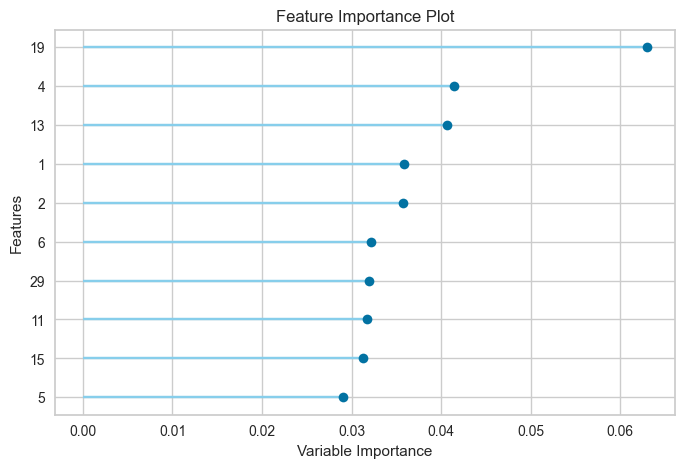

In [84]:
plot_model(xgboost_model, plot='feature')

In [86]:
xgb_model = xgb.XGBClassifier(random_state=10)

rfe = RFE(estimator=xgb_model, n_features_to_select=10, step=1)

pipeline = Pipeline(steps=[
    ('feature_selection', rfe),
    ('classifier', xgb_model)
])

X = df_combined.drop('label', axis=1)
y = df_combined['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

pipeline.fit(X_train, y_train)

selected_features = X_train.columns[pipeline.named_steps['feature_selection'].support_]
print(f'Características seleccionadas: {selected_features}')

Características seleccionadas: Index([0, 1, 2, 4, 5, 8, 10, 11, 13, 14], dtype='object')


In [87]:
xgb_model_reduced = xgb.XGBClassifier(random_state=10)
X_train_selected = pipeline.named_steps['feature_selection'].transform(X_train)
X_test_selected = pipeline.named_steps['feature_selection'].transform(X_test)

xgb_model_reduced.fit(X_train_selected, y_train)

accuracy = xgb_model_reduced.score(X_test_selected, y_test)
print(f'Precisión del modelo con características seleccionadas: {accuracy}')

y_pred = xgb_model_reduced.predict(X_test_selected)

Precisión del modelo con características seleccionadas: 0.9448550312677658


5. 
El rendimiento del modelo es similar, ya que en términos de accuracy tienen valores cercanos, 0.94 y 0.93. En cuanto a robustez, debería ser menos sensible a cambios por la selección de variables pero no debería ser un cambio mayor. 

Con menos variables es más fácil entrenar, interpretar y gestionar un modelo, porque es menos sensible a cambios y al tener menos variabilidad los resultados son más robustos y estables. Sin variables inecesarias se reducen las posibilidades de overfitting, porque el modelo no se ajustaría a casos tan específicos. 

Al tener menos variables es más fácil de explicar porque son menos casos de ajuste. Tanto el comportamiento del modelo como la compresión son más simples porque se entiende más que variables tienen mayor impacto. 

### 2.3 Calibración Probabilistica [6 puntos]

<center>
<img src='https://media2.giphy.com/media/l2Je4Ku0Cx292KWv6/200w.gif?cid=6c09b952y0sihtq9tb6sz8j2023x3zxxp3qx1ocgonkpkblj&ep=v1_gifs_search&rid=200w.gif&ct=g' width=400 />

Para lograr modelos más modulares, se recomienda realizar una calibración del modelo entrenado anteriormente, con el objetivo de obtener salidas que reflejen mayor modularidad.

1. Se solicita que utilice un método de calibración que asegure que las probabilidades generadas incrementen de manera monótona. Una métrica ampliamente utilizada para evaluar la precisión de la calibración de un modelo es el Brier Score. Calcule el Brier Score para el modelo tanto antes como después de la calibración. Esto le permitirá realizar una comparación cuantitativa y determinar si la calibración ha mejorado el rendimiento del modelo. Para más información sobre el Brier Score, puede consultar el siguiente enlace: [Scikit-Learn - Brier Score Loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html). [3 puntos]

2. Tras la calibración, examine y comente los resultados obtenidos. A su análisis añada una comparación visual de las ideales versus las salidas del modelo original (sin calibrar) y del modelo calibrado. [3 puntos]

**Respuesta**

In [21]:
y_prob = xgb_model_reduced.predict_proba(X_test_selected)[:, 1] 

brier_score_before = brier_score_loss(y_test, y_prob)
print(f'Brier Score antes de la calibración: {brier_score_before}')

Brier Score antes de la calibración: 0.04905618139184181


In [22]:
calibrated_model = CalibratedClassifierCV(estimator=xgb_model_reduced, method='isotonic', cv='prefit')

calibrated_model.fit(X_test_selected, y_test)

CalibratedClassifierCV(cv='prefit', ensemble=True,
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=None, n_jobs=None,
                                               num_parallel_tree=None,
                                               objective='binary:logistic', ...),
                       method='isotonic', n_jobs=None)

In [23]:
y_prob_calibrated = calibrated_model.predict_proba(X_test_selected)[:, 1]

brier_score_after = brier_score_loss(y_test, y_prob_calibrated)
print(f'Brier Score después de la calibración: {brier_score_after}')

Brier Score después de la calibración: 0.04636078717205764


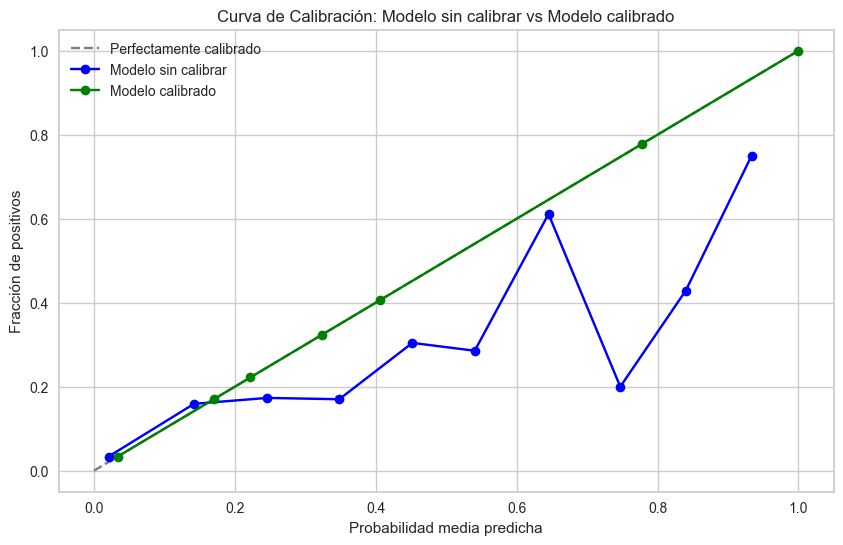

In [24]:
y_prob = xgb_model_reduced.predict_proba(X_test_selected)[:, 1]
y_prob_calibrated = calibrated_model.predict_proba(X_test_selected)[:, 1]

fraction_of_positives_orig, mean_predicted_value_orig = calibration_curve(y_test, y_prob, n_bins=10)
fraction_of_positives_cal, mean_predicted_value_cal = calibration_curve(y_test, y_prob_calibrated, n_bins=10)

plt.figure(figsize=(10, 6))

plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectamente calibrado', color='gray')

plt.plot(mean_predicted_value_orig, fraction_of_positives_orig, marker='o', label='Modelo sin calibrar', color='blue')

plt.plot(mean_predicted_value_cal, fraction_of_positives_cal, marker='o', label='Modelo calibrado', color='green')

plt.title('Curva de Calibración: Modelo sin calibrar vs Modelo calibrado')
plt.xlabel('Probabilidad media predicha')
plt.ylabel('Fracción de positivos')
plt.legend()
plt.show()

2.

El modelo no calibrado tiene comportamiento irregular, como se ve la línea azul del gráfico, sobre todo a medida que aumenta la probabilidad media. El modelo calibrado es más estable, por lo que su predicciones son más confiables, respecto a lo que se observa en el gráfico. En resumen, la calibración mejoró la confiabilidad del modelo, mejorando el estado de las probabilidades predichas y resultados reales. 